In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [0]:
# from google.colab import files
# files.upload()

**Get Model files and Datasets from cloud APIs**

In [3]:
!wget https://storage.googleapis.com/columbia_applied_deep_learning/demand_forecasting.zip  \
    -O ./demand_forecasting.zip

--2019-05-19 04:25:49--  https://storage.googleapis.com/columbia_applied_deep_learning/demand_forecasting.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 2607:f8b0:4001:c0e::80
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3361698 (3.2M) [application/zip]
Saving to: ‘./demand_forecasting.zip’

./demand_forecastin 100%[===================>]   3.21M  --.-KB/s    in 0.03s   

2019-05-19 04:25:49 (106 MB/s) - ‘./demand_forecasting.zip’ saved [3361698/3361698]



In [0]:
import zipfile
local_zip = './demand_forecasting.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [5]:
!ls -al

total 7284
drwxr-xr-x 1 root root    4096 May 19 03:38 .
drwxr-xr-x 1 root root    4096 May 19 03:37 ..
drwxr-xr-x 1 root root    4096 May 16 16:08 .config
-rw-r--r-- 1 root root 3361698 May 19 03:13 demand_forecasting.zip
drwxr-xr-x 2 root root    4096 May 19 03:38 __MACOSX
-rw-r--r-- 1 root root  189008 May 19 04:26 model1_eu.hdf5
-rw-r--r-- 1 root root  188968 May 19 04:26 model1_id2.hdf5
-rw-r--r-- 1 root root  171048 May 19 04:26 model1_th.hdf5
-rw-r--r-- 1 root root  901416 May 19 04:26 model2_eu.hdf5
-rw-r--r-- 1 root root  901312 May 19 04:26 model2_id2.hdf5
-rw-r--r-- 1 root root  901312 May 19 04:26 model2_th.hdf5
-rw-r--r-- 1 root root  150744 May 19 04:26 model3_eu.hdf5
-rw-r--r-- 1 root root  150744 May 19 04:26 model3_id2.hdf5
-rw-r--r-- 1 root root  150744 May 19 04:26 model3_th_exp_120.hdf5
-rw-r--r-- 1 root root  150744 May 19 04:26 model3_th_exp.hdf5
-rw-r--r-- 1 root root  142760 May 19 04:26 model3_th.hdf5
-rw-r--r-- 1 root root    8090 May 19 04:26 Product1-Dataset

**Imports**

In [6]:
import pandas as pd
import numpy as np
import argparse
import os
import platform
import datetime, time
import datetime as dt
import warnings
from IPython.core.display import display, HTML
import tensorflow as tf
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Input, LSTM, TimeDistributed,RepeatVector, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,RemoteMonitor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import load_model
import sys
import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('default')
plt.style.use('seaborn-deep')
sns.set(style="whitegrid")
sns.set_context("talk")

%matplotlib inline
init_notebook_mode(connected=True)

In [0]:
checkpoint_dir = './'
model_filename = 'model2_eu.hdf5'
data_filename = 'Product3-Dataset-eu-2year.csv'
train_model=False

In [8]:
tf.__version__

'2.0.0-alpha0'

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
def plotly_df(df, title='', annotations=None):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines+markers')
    xaxis = dict(title='Time Steps',type='date', rangeslider=dict(visible=True))
    
    data = [go.Scatter(y=df[c], name=c,  **common_kw) for c in df.columns]
    layout = dict(title=title, showlegend=True, annotations=annotations, xaxis=xaxis, )
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [0]:
def create_timeseries_dataset(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var_lag%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var_roll%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var_roll%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [0]:
def timeseries_train_test_split(X, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    train = X[:test_index]
    test = X[test_index:]
    
    return train, test

**Read the Dataset & add index**

In [0]:
df_raw = pd.read_csv(filepath_or_buffer=data_filename, header=0, names=None, usecols=['date', 'sale_amt'], parse_dates=[0])

In [0]:
df_raw.index = df_raw.date
df_raw.drop(['date'], inplace=True, axis=1)

**Plot the dataset**

In [15]:
configure_plotly_browser_state()
plotly_df(df_raw, title='Timeseries')

**Dropping first few days as there is no defined pattern in the beginnig of business**

In [0]:
df_raw =df_raw[94:-1]

In [17]:
configure_plotly_browser_state()
plotly_df(df_raw, title='Timeseries')

**Convert the data to timeseries format; Split the data into test and training sets**

In [0]:
timesteps=63
rolling_days=14
df_to_ts = create_timeseries_dataset(df_raw, n_in=timesteps, n_out=rolling_days, dropnan=True)

In [0]:
train_dataset, test_dataset = timeseries_train_test_split(df_to_ts, 0.12)

In [20]:
print (train_dataset.shape, test_dataset.shape)

(499, 77) (69, 77)


**Scale the data using MinMaxScaler**

In [21]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_dataset)

train_scaled = scaler.transform(train_dataset)
test_scaled = scaler.transform(test_dataset)

x_train_scaled = train_scaled[:, :timesteps]
y_train_scaled = train_scaled[:, timesteps:]

x_test_scaled = test_scaled[:, :timesteps]
y_test_scaled = test_scaled[:, timesteps:]

print('test_scaled shape: '  + str(test_scaled.shape))
print('train_scaled shape: '  + str(train_scaled.shape))

test_scaled shape: (69, 77)
train_scaled shape: (499, 77)


**Model Definition**

In [22]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((timesteps, 1), input_shape=(timesteps,)))
model.add(tf.keras.layers.LSTM(32, return_sequences=True))
model.add(tf.keras.layers.LSTM(32, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(Dense(64)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(rolling_days))
model.compile('adam', loss='mse')


W0519 04:27:56.528045 139703937574784 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f0ee5827be0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0519 04:27:57.244809 139703937574784 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f0ee469b0b8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 63, 1)             0         
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (None, 63, 32)            4352      
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (None, 63, 32)            8320      
_________________________________________________________________
time_distributed (TimeDistri (None, 63, 64)            2112      
_________________________________________________________________
dropout (Dropout)            (None, 63, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 4032)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                5

In [0]:
validation_data = (x_test_scaled, y_test_scaled)
c = [
            ModelCheckpoint(checkpoint_dir + model_filename, save_best_only=True,monitor='val_loss', mode='min', verbose=1, period=1),
            EarlyStopping(monitor='val_loss', min_delta=0, patience=200, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=55, min_lr=0.0001, verbose=1)]#,
            

In [0]:
if train_model:
  history = model.fit(x_train_scaled, y_train_scaled, epochs=1200,verbose=1, batch_size=14, validation_data=validation_data, callbacks=c, shuffle=False)

Train on 498 samples, validate on 70 samples
Epoch 1/1500
490/498 [============================>.] - ETA: 0s - loss: 0.1713
Epoch 00001: val_loss improved from inf to 0.19232, saving model to /content/model2_eu.hdf5
498/498 [==============================] - 1s 3ms/sample - loss: 0.1706 - val_loss: 0.1923
Epoch 2/1500
490/498 [============================>.] - ETA: 0s - loss: 0.1265
Epoch 00002: val_loss improved from 0.19232 to 0.17115, saving model to /content/model2_eu.hdf5
498/498 [==============================] - 1s 1ms/sample - loss: 0.1263 - val_loss: 0.1711
Epoch 3/1500
476/498 [===========================>..] - ETA: 0s - loss: 0.1196
Epoch 00003: val_loss improved from 0.17115 to 0.16865, saving model to /content/model2_eu.hdf5
498/498 [==============================] - 1s 1ms/sample - loss: 0.1188 - val_loss: 0.1686
Epoch 4/1500
462/498 [==========================>...] - ETA: 0s - loss: 0.1153
Epoch 00004: val_loss improved from 0.16865 to 0.15988, saving model to /content/m

**Save the model for future prediction**

In [0]:
# from google.colab import files
# files.download(model_filename)

**Plot Training and Validation loss**

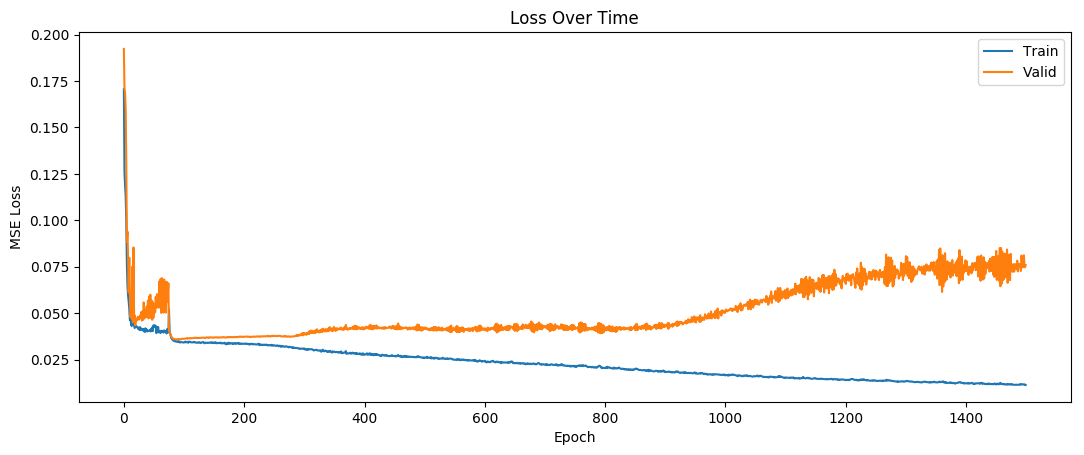

In [0]:
if train_model:  
  plt.style.use('default')
  fig, ax = plt.subplots(facecolor='w')
  fig.set_size_inches(fig.get_figwidth() * 2.0, fig.get_figheight() * 1.0)

  ax.plot(history.history['loss'])
  ax.plot(history.history['val_loss'])

  plt.xlabel('Epoch')
  plt.ylabel('MSE Loss')
  plt.title('Loss Over Time')
  plt.legend(['Train','Valid'])
  plt.show()

**Load saved model for predictions**

In [25]:
model_from_file = load_model(checkpoint_dir + model_filename)

W0519 04:29:15.892012 139703937574784 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f0ee58273c8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0519 04:29:15.978615 139703937574784 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f0ed8003208>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


**This function predicts on the training dataset and returns Original and Predicted values as two separate dataframes**

In [0]:
def inverse_transform_out(scaler=scaler, x_scaled=x_test_scaled, y_scaled=y_test_scaled, dataset=test_dataset, from_model=model):
  
  # This function creates dataframes for true and predicted values. It can be called for train, test and validation datasets. 
  # Uses the model, scaler and scaled datasets as inputs
  # output is two dataframes; one for true rolling days values and the other for predictions
  
  yhat = from_model.predict(x_scaled)
  
  pred_cols = ['pred_'+str(i) for i in range(1, rolling_days+1)]
  scaler_input = np.concatenate([x_scaled, yhat], axis=1)
  scaler_output = scaler.inverse_transform(scaler_input)
  df_pred = pd.DataFrame(scaler_output[:, timesteps:],columns=pred_cols)
  df_pred.index = dataset.index
  
  true_cols = ['true_'+str(i) for i in range(1,rolling_days+1)] 
  scaler_input = np.concatenate([x_scaled, y_scaled], axis=1)
  scaler_output = scaler.inverse_transform(scaler_input)
  df_true = pd.DataFrame(scaler_output[:, timesteps:],columns=true_cols)    
  df_true.index = dataset.index
  
  return df_true, df_pred

**Prediction for a given date**

In [0]:
def prediction(start_dt, df_true, df_pred):
  
  end_date= start_dt + datetime.timedelta(rolling_days - 1 )
  idx = pd.date_range(start=start_dt, end=end_date)
  dt_pred = df_pred.loc[start_dt]
  dt_pred.index = idx
  dt_true = df_true.loc[start_dt]
  dt_true.index = idx
  results = pd.concat([dt_true,dt_pred], axis=1)
  results.columns=['Original','Predicted']
  
  return results

**MAPE Function**

In [0]:
def mean_absolute_percentage_error(y_pred, y_true): 
    return np.mean(np.abs((y_pred - y_true)) / (y_pred+ 1e-7)) * 100

**Inference plots and Evaluation Metrics**

In [0]:
df_true, df_pred = inverse_transform_out(from_model=model_from_file)

In [0]:
results = prediction(datetime.datetime(2019,3,4), df_true, df_pred)

In [31]:
configure_plotly_browser_state()
plotly_df(results, title="Predictions")

In [32]:
configure_plotly_browser_state()
plotly_df(df_raw, title="Dataset")

In [33]:
rmse = math.sqrt(mean_squared_error(results['Original'].values, results['Predicted'].values))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 15920.412


In [34]:
mape = mean_absolute_percentage_error(np.array(results['Predicted'].values),np.array(results['Original'].values))
print ('Test MAPE: %.3f' %mape)

Test MAPE: 11.447


In [35]:
err = (abs(sum(results['Predicted'].values) - sum(results['Original'].values)) / (sum(results['Original'].values))) *100
print ('Prediction Error: %.2f%%' %err)

Prediction Error: 10.35%
